# Background

The MBTA community law requires a by-right zone of 15 units per acre. There are [sources](https://mrsc.org/stay-informed/mrsc-insight/april-2017/visualizing-compatible-density) of images of different density levels online, but it's hard to understand in the abstract without a local example to refer to. This should answer the question 'what does this level of density look like in my community?'

In [1]:
# data i/o
from data.connect_db import get_db

# plotting
import seaborn as sns
import folium

# processing
import geopandas as geo_pd
import pandas as pd
import numpy as np

# misc
import os
from concurrent.futures import as_completed, ProcessPoolExecutor
from tqdm.auto import tqdm

from math import pi, sqrt

%matplotlib inline

con = get_db()

tqdm.pandas()

In [2]:
# neighboring cities are needed to get the true densities on the edges
cities = {
    "WALTHAM": {
      "id": "308",
      "FY": "23",
      "CY": "22"
    },
    "LEXINGTON" : {
        "id": "155",
        "FY": "22",
        "CY": "22"
    },
    "LINCOLN" : {
        "id": "157",
        "FY": "23",
        "CY": "22"
    },
    "WESTON" : {
        "id": "333",
        "FY": "22",
        "CY": "22"
    },
    "NEWTON" : {
        "id": "207",
        "FY": "23",
        "CY": "22" 
    },
    "WATERTOWN": {
        "id": "314",
        "FY": "23",
        "CY": "22"
    },
    "BELMONT" : {
        "id": "026",
        "FY": "23",
        "CY": "23"
    }
}

MBTA_density = 15

# 1 acre in m^2
ACRE_TO_M2 = 4046.86

In [3]:
property_shapefiles_df = []
assessments_df = []

for city, data in tqdm(cities.items()):
    city_id = data["id"]
    CY = data["CY"]
    FY = data["FY"]
    
    query = f"""
    select
        *
    from 
        \"M{city_id}TaxPar_CY{CY}_FY{FY}\"
    """

    property_shapefiles_df.append(geo_pd.read_postgis(query, con))
    
    query = f"""
    select
        *
    from
        \"M{city_id}Assess_CY{CY}_FY{FY}\"
    """
    
    assessments_df.append(pd.read_sql(query, con))

property_shapefiles_df = geo_pd.GeoDataFrame(pd.concat(property_shapefiles_df, ignore_index=True))

assessments_df = pd.concat(assessments_df, ignore_index=True)

# data cleanup
property_shapefiles_df["SHAPE_Area"] = property_shapefiles_df["SHAPE_Area"] / ACRE_TO_M2
property_shapefiles_df = property_shapefiles_df[["LOC_ID", "TOWN_ID", "geom", "SHAPE_Area"]]
assessments_df = assessments_df[["LOC_ID", "USE_CODE", "SITE_ADDR", "UNITS", "TOWN_ID"]]

# remove some strange parcels with characters in the use code
assessments_df = assessments_df[assessments_df["USE_CODE"].map(lambda x: x.isnumeric())]

# TODO:
# what about use codes > 1000? is this even valid?
assessments_df["USE_CODE"] = assessments_df["USE_CODE"].astype(int)

print(f"total parcels = {len(property_shapefiles_df)}")

  0%|          | 0/7 [00:00<?, ?it/s]

total parcels = 70705


In [4]:
property_shapefiles_df.head()

,LOC_ID,TOWN_ID,geom,SHAPE_Area
0,F_720118_2954451,308,"MULTIPOLYGON (((219510.406 900516.563, 219505....",0.103024
1,F_720144_2954524,308,"MULTIPOLYGON (((219521.229 900544.743, 219512....",0.216257
2,F_722474_2954539,308,"MULTIPOLYGON (((220212.276 900527.633, 220199....",0.102640
3,F_720055_2954540,308,"MULTIPOLYGON (((219481.807 900560.359, 219483....",0.265953
4,F_720183_2954604,308,"MULTIPOLYGON (((219530.434 900568.770, 219524....",0.152051


In [5]:
assessments_df.head()

,LOC_ID,USE_CODE,SITE_ADDR,UNITS,TOWN_ID
0,F_734012_2963106,101,31 CLEMENTS RD,1,308
1,F_730830_2973583,101,4 ABBOTT RD,1,308
2,F_730659_2973534,101,15 ABBOTT RD,1,308
3,F_730718_2973342,101,22 ABBOTT RD,1,308
4,F_730548_2973294,101,33 ABBOTT RD,1,308


In [6]:
property_shapefiles_df['centroid'] = property_shapefiles_df['geom'].apply(lambda x: x.centroid)

properties_df = property_shapefiles_df.merge(assessments_df, on=["LOC_ID", "TOWN_ID"], how="left")

properties_df.head()

,LOC_ID,TOWN_ID,geom,SHAPE_Area,centroid,USE_CODE,SITE_ADDR,UNITS
0,F_720118_2954451,308,"MULTIPOLYGON (((219510.406 900516.563, 219505....",0.103024,POINT (219492.454 900518.533),101.0,759 SOUTH ST,1.0
1,F_720144_2954524,308,"MULTIPOLYGON (((219521.229 900544.743, 219512....",0.216257,POINT (219500.236 900540.754),104.0,753 -55 SOUTH ST,2.0
2,F_722474_2954539,308,"MULTIPOLYGON (((220212.276 900527.633, 220199....",0.102640,POINT (220210.372 900545.361),132.0,72 LOT EDGEWATER DR,0.0
3,F_720055_2954540,308,"MULTIPOLYGON (((219481.807 900560.359, 219483....",0.265953,POINT (219473.170 900545.465),101.0,757 SOUTH ST,1.0
4,F_720183_2954604,308,"MULTIPOLYGON (((219530.434 900568.770, 219524....",0.152051,POINT (219512.264 900565.209),101.0,749 SOUTH ST,1.0


In [7]:
# find the radius - we want 1 acre in the unit of the CRS,
# which is apparently in meters (https://www.mass.gov/info-details/overview-of-massgis-data)

radius = sqrt(ACRE_TO_M2 / pi)

print(radius)  # radius of the circle to draw around each parcel centroid, in meters

35.89088388437564


## Local density calculation

Density is a neighborhood feeling, and typically we use units per acre in the US to describe this. The calculation below
will draw a circle around every parcel within Waltham such that the radius gives us a 1 acre area around the parcel.
Then we compare the centroids of other parcels within Waltham and neighboring cities (since they have an effect
on the edges of Waltham) to find the neighboring parcels. Then we just sum the `UNITS` field of all parcels within
that circle to get the units per acre count.

N.B. this calculation can be slow, so it will be distributed among other processor cores on your machine. it may get a little loud...

In [8]:
from investigations.housing_density.calc_local_density import calc_local_density

pbar = tqdm(total=len(properties_df.index))
with ProcessPoolExecutor() as executor:
    n_chunks = os.cpu_count()
    chunks = np.array_split(properties_df.index, 100)
    futures = [executor.submit(calc_local_density, properties_df, chunk) for chunk in chunks]

    for future in as_completed(futures):
        results = future.result()
        exception = future.exception()
        if exception:
            print(exception)
            continue
        for pair in results:
            properties_df.at[pair[0], "LOCAL_DENSITY"] = pair[1]
            pbar.update()


  0%|          | 0/86029 [00:00<?, ?it/s]

Filter out the parcels from outside the city (TOWN_ID != 308) and print the value counts.

The most frequently seen density values are in the low single digits, which shouldn't be much of a surprise given how many single family homes we have.

In [9]:
properties_df = properties_df[properties_df["TOWN_ID"] == int(cities["WALTHAM"]["id"])]
properties_df["LOCAL_DENSITY"].value_counts()

LOCAL_DENSITY
3.0      2310
4.0      1758
5.0      1325
6.0      1127
0.0      1017
         ... 
201.0       1
148.0       1
163.0       1
200.0       1
269.0       1
Name: count, Length: 82, dtype: int64

Just for pure interest, which parcel has the max local neighborhood density?

In [10]:
properties_df[properties_df["LOCAL_DENSITY"] == properties_df["LOCAL_DENSITY"].max()]["SITE_ADDR"]

15154    976  LEXINGTON ST
Name: SITE_ADDR, dtype: object

## The whole city, plotted

Most of the city is very low density, as we saw before with the mode at 3 units per acre. I'm guessing minimum lot sizes zoning requirements are driving that number down.

Text(0.5, 1.0, '1 acre area dwelling unit density')

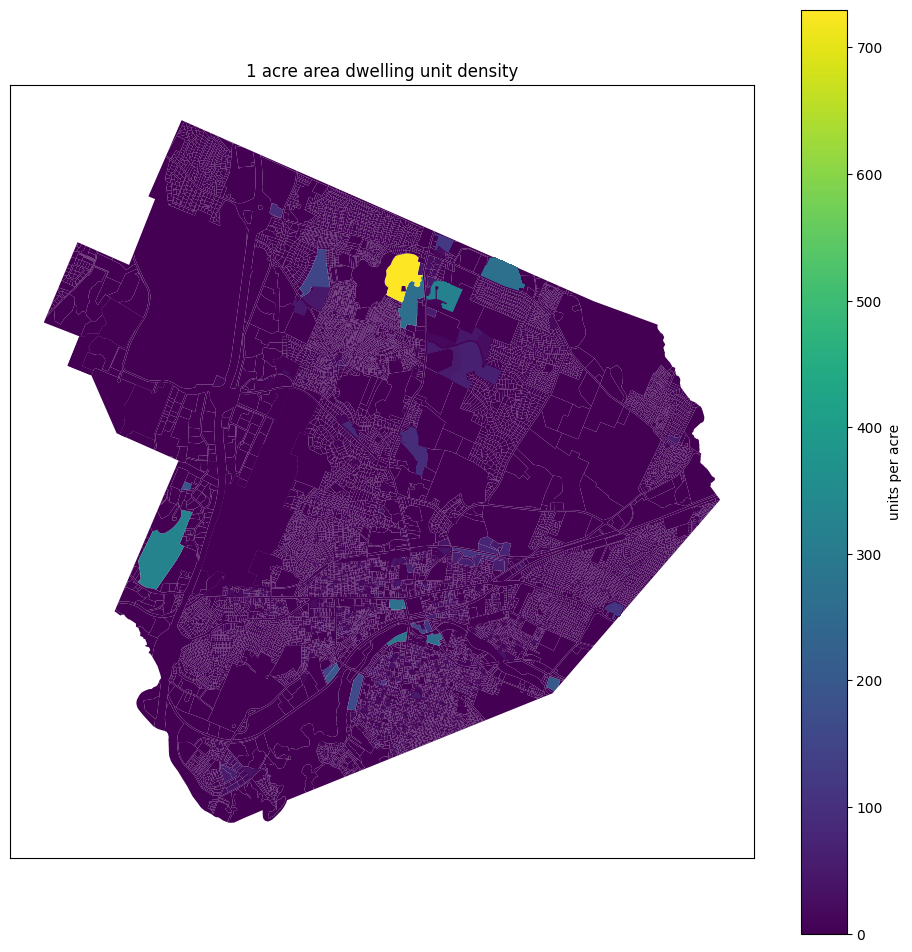

In [11]:
ax = properties_df.plot(column="LOCAL_DENSITY", legend=True, legend_kwds={'label': "units per acre"}, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax.set_title("1 acre area dwelling unit density")

## Plotting the parcels

Unsurprisingly, they're all clustered near the river.

<Axes: >

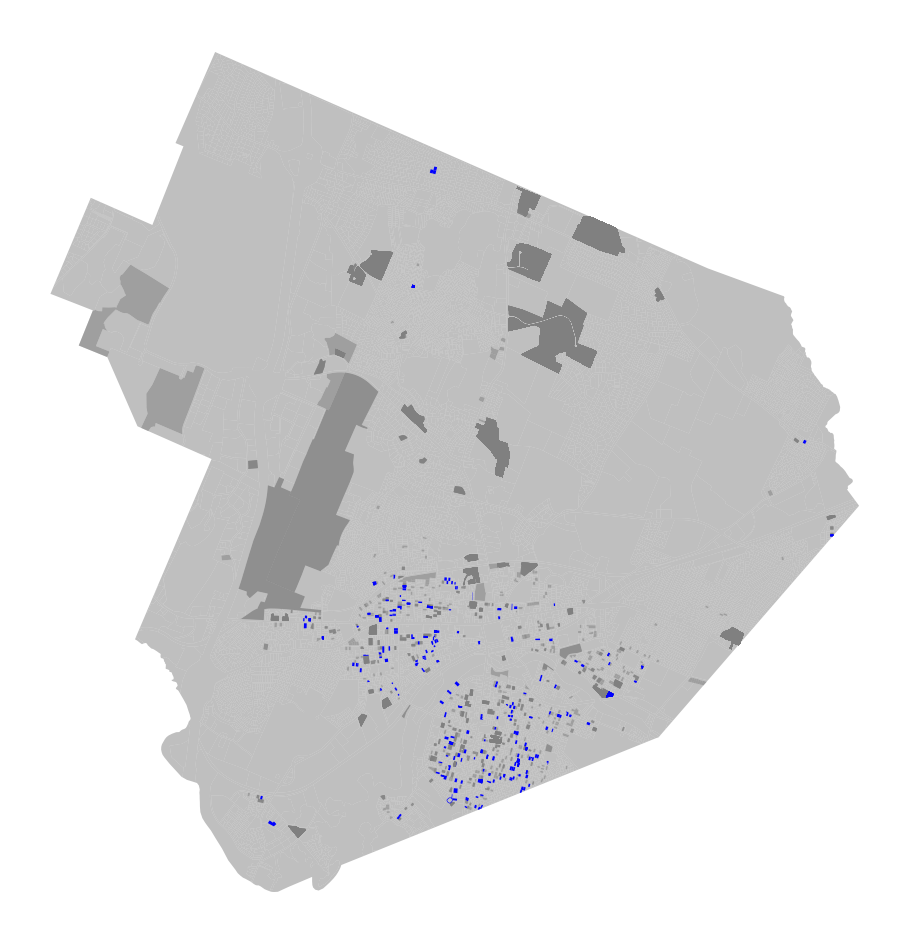

In [12]:
# plot the actual dense areas
base = properties_df.plot(color="gray", alpha=0.5, figsize=(12, 12))
base.set_axis_off()
MBTA_zoned_density_examples_df = properties_df[properties_df["LOCAL_DENSITY"] == MBTA_density]
MBTA_zoned_density_examples_df.plot(color="blue", zorder=100, ax=base)

## Existing parcels at or exceeding the MBTA density requirements

The law requires densities of 15 units / acre by-right. How many parcels do we have like this?

In [13]:
# parcels w/ >= 15 local density
meets_density_count = len(properties_df[properties_df["LOCAL_DENSITY"] >= MBTA_density])

# remainder
low_density_count = len(properties_df[properties_df["LOCAL_DENSITY"] < MBTA_density])

print(f"{low_density_count} / {len(properties_df)} are low density")
print(f"{meets_density_count} / {len(properties_df)} meet the minimum MBTA density (citywide)")

13356 / 16813 are low density
3457 / 16813 meet the minimum MBTA density (citywide)


What about the number of units in these parcels?

In [14]:
# TODO: recalculate for only parcels that are in residential use codes?

# household unit counts in each group
meets_density_unit_count = properties_df[properties_df["LOCAL_DENSITY"] >= MBTA_density]["UNITS"].sum()

# remainder
low_density_unit_count = properties_df[properties_df["LOCAL_DENSITY"] < MBTA_density]["UNITS"].sum()

total_units = properties_df["UNITS"].sum()

print(f"{low_density_unit_count} / {total_units} unit counts in low density")
print(f"{meets_density_unit_count} / {total_units} unit counts in minimum MBTA density (citywide)")

19239.0 / 30942.0 unit counts in low density
11703.0 / 30942.0 unit counts in minimum MBTA density (citywide)


That's looking much better! A good chunk of the units are in parcels of this density, which means there's a good chance you've spent time near or
in an area of this density. If we change our scale so the peak means '>15 units per acre', we'll get the plot below:

Text(0.5, 1.0, 'parcel local density')

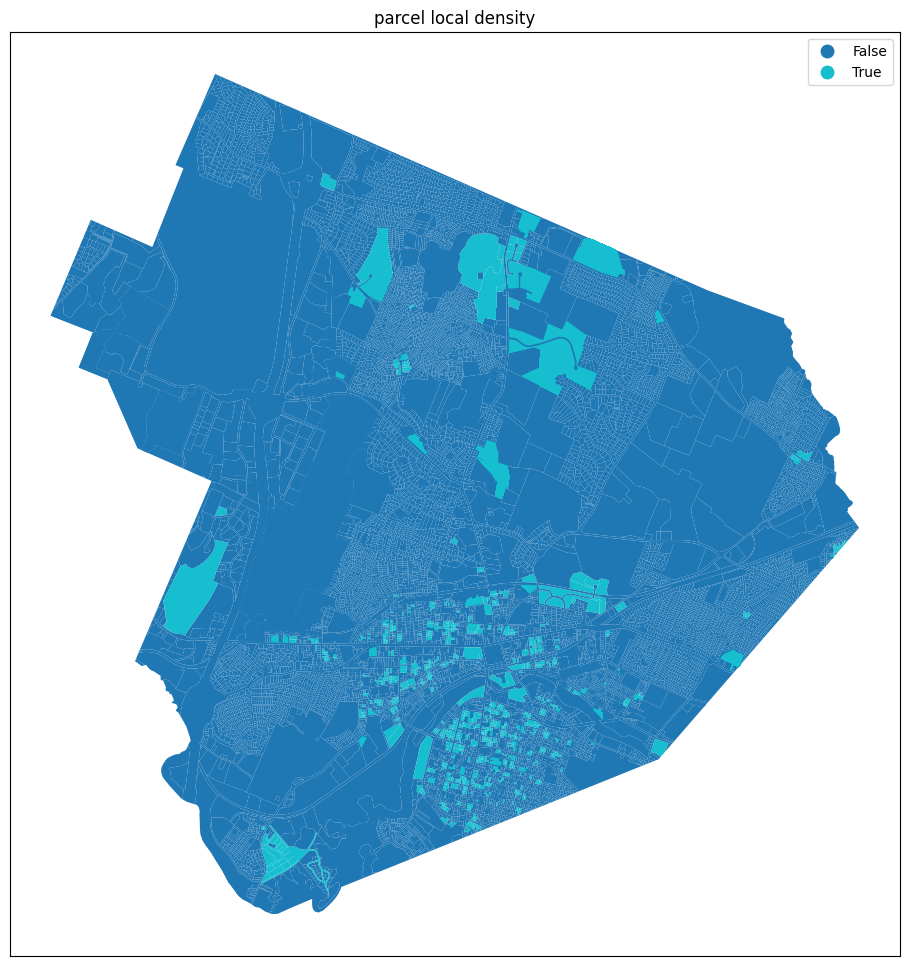

In [15]:
# TODO: it's a pretty plot, but maybe just a binary (meets / doesn't meet) would be better?

filtered_df = properties_df.copy()
filtered_df["MEETS_MBTA_DENSITY"] = filtered_df["LOCAL_DENSITY"].apply(lambda x: x > MBTA_density)
filtered_df.head()
ax = filtered_df.plot(column="MEETS_MBTA_DENSITY", legend=True, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax.set_title("parcel local density")

# Parcel-level density

The zoning change that actually counts for the MBTA communities law is the number of units per acre - that's a straightforward calculation.

In [16]:

# TODO: check this for non-residential parcels

properties_df["PARCEL_DENSITY"] = properties_df["UNITS"] / (properties_df["SHAPE_Area"])

# zero it out for non-residential though
properties_df["PARCEL_DENSITY"] = properties_df.apply(lambda row: 0 if row["USE_CODE"] > 200 else row["PARCEL_DENSITY"], axis="columns")

properties_df["MEETS_MBTA_DENSITY"] = properties_df["PARCEL_DENSITY"].apply(lambda x: x > MBTA_density)

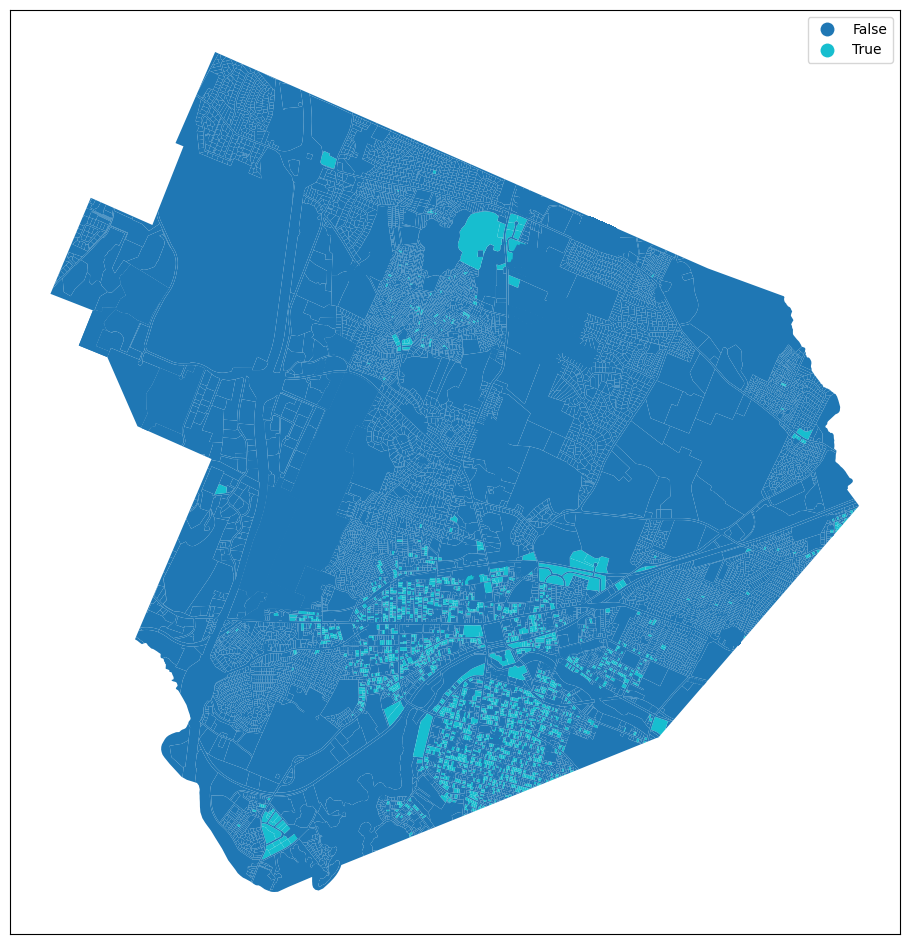

In [17]:
ax = properties_df.plot(column="MEETS_MBTA_DENSITY", legend=True, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

### Web map

In [19]:
map_df = properties_df[properties_df["TOWN_ID"] == 308]

# TODO: why does this fail with a KeyError exception?
map_df["UNITS"] = map_df.apply(lambda row: 0 if row["USE_CODE"] > 200 else row["UNITS"], axis="columns")
map_df.rename({"UNITS": "RES_UNITS"}, inplace=True, axis='columns')
map_df = map_df[["LOC_ID", "RES_UNITS", "SITE_ADDR", "LOCAL_DENSITY", "geom"]]
map_df.to_crs("EPSG:4326", inplace=True)

In [20]:
center = [42.3, -71.2]
bounds = map_df.total_bounds.tolist()
m = folium.Map(
    location=center,
    zoom_start=10,
    tiles="cartodbpositron",
    max_bounds=True,
    max_width=800,
)

# TODO:
# is there anyway to restrict the actual panning bounds of the map?
m.fit_bounds([bounds[:2][::-1], bounds[2:][::-1]])

tooltip = folium.GeoJsonTooltip(
    fields=[
        "SITE_ADDR",
        "RES_UNITS",
        "LOCAL_DENSITY",
    ],
    aliases=[
        "Address",
        "Residential units",
        "Local density",
    ],
    localize=True,
    sticky=False,
    labels=True,
    style="""
        background-color: #F0EFEF;
        border: 2px solid black;
        border-radius: 3px;
        box-shadow: 3px;
    """,
    min_zoom=2,
)

folium.Choropleth(
    map_df,
    tooltip=tooltip,
    bins=9,
    fill_color="YlOrRd",
    columns=("LOC_ID", "LOCAL_DENSITY"),
).add_to(m)

def fill_rule(feature):
    return {
        "color": "transparent",
        "fillColor": "transparent"
    }

folium.GeoJson(
    map_df, style_function=lambda feature: fill_rule(feature), tooltip=tooltip
).add_to(m)


In [ ]:
#m

In [21]:
os.makedirs("html", exist_ok=True)
m.save("html/housing_density.html", bounds=(bounds[:2][::-1] + bounds[2:][::-1]), maxBoundsViscosity=1.0)